# Do some basic testing with existing implementations to see if everything works as expected

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs
from scipy.linalg import dft
from scipy.io import wavfile
from scipy.sparse.linalg import eigs
from scipy.signal import stft # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html
import matplotlib.pyplot as plt
from icecream import ic # Logging/debug library
from dataReader import DATA_PATH, SAMPLE_PATH

from dimensionalityReduction import getPCA, getICA, getNMF

In [2]:
def frameData(data, W, H, L):
    framedData = np.zeros((W, L//H))
    for frameIdx, frameRange in enumerate(range(0, L-W, H)):
        framedData[:, frameIdx] = data[frameRange:frameRange+W]

    return framedData

def getMagnitudeSpectrogram(W=1024, H=256, PRE_PADDING=0, filename='vl1.wav'):

    F = dft(W)
    PRE_PADDING = 0
    sampleRate, data = wavfile.read(filename)

    data = data.astype(np.float64)
    L = data.shape[0]

    extendLength = H - (L % H)
    data = np.pad(data, (H*PRE_PADDING, extendLength))
    L = data.shape[0]

    if len(data.shape) > 1:
        data = np.average(data, axis=1)

    framedData = frameData(data, W=W, H=H, L=L)
    framedData = framedData * np.hanning(W)[:, np.newaxis]

    spectrogram = np.dot(F, framedData)
    specMagnitude = np.abs(spectrogram)
    specLogged = np.log(specMagnitude+1e-6)
    
    # Cut spectrogram in half
    finalSpectrogram = specLogged[:W//2, :]
    # finalSpectrogram = specMagnitude[:W//2, :]

    return np.clip(finalSpectrogram, a_min=0, a_max=np.inf)

ic| SAMPLE_PATH: 'data/vl1.wav'
ic| data.shape: (88973,)


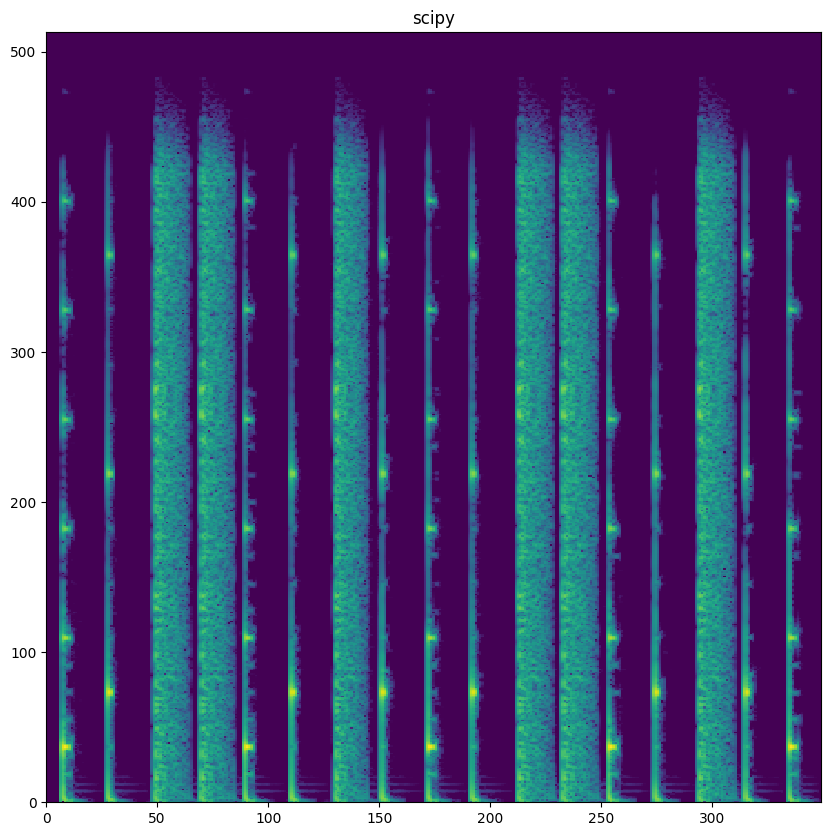

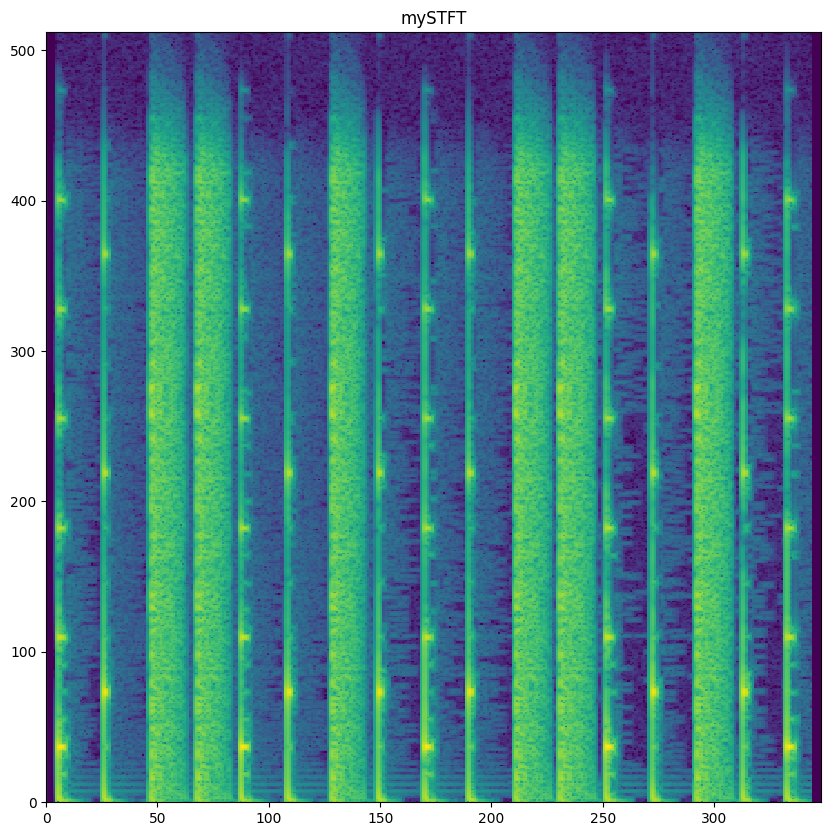

In [3]:
ic(SAMPLE_PATH)

sample_rate, data = wavfile.read(SAMPLE_PATH)

ic(data.shape)

mySTFT = getMagnitudeSpectrogram(filename=SAMPLE_PATH)

# stft returns a tuple of (sample frequencies, segment times, the STFT itself)
scipySTFT = stft(data, fs=sample_rate, window='hann', nperseg=1024, noverlap=3*1024//4)

# convertedScipySTFT = np.abs(scipySTFT[-1])
# convertedScipySTFT = np.log(np.abs(scipySTFT[-1]))
convertedScipySTFT = np.clip(np.log(np.abs(scipySTFT[-1])), a_min=0, a_max=np.inf)

plt.figure(figsize=(10, 10))
plt.pcolormesh(convertedScipySTFT), plt.title('scipy')
plt.show()

plt.figure(figsize=(10, 10))
plt.pcolormesh(mySTFT), plt.title('mySTFT')
plt.show()

## Try doing dimensionality reduction with PCA, ICA, and NMF

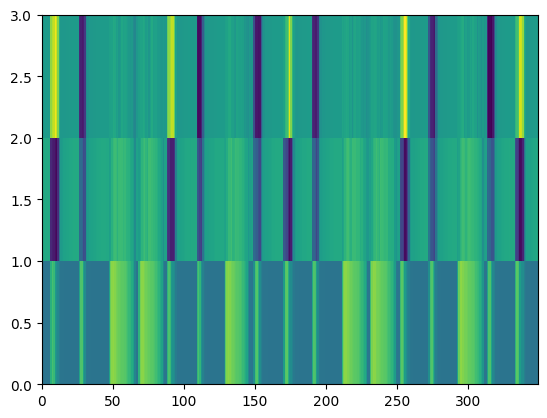

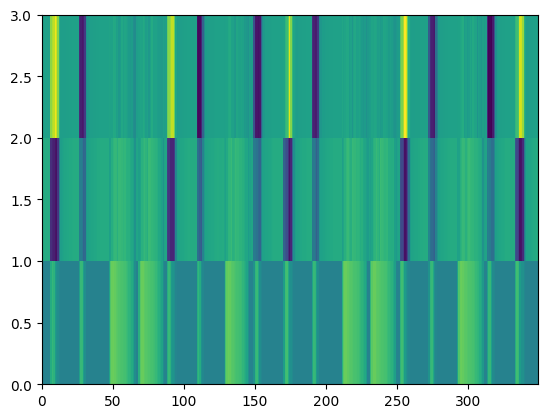

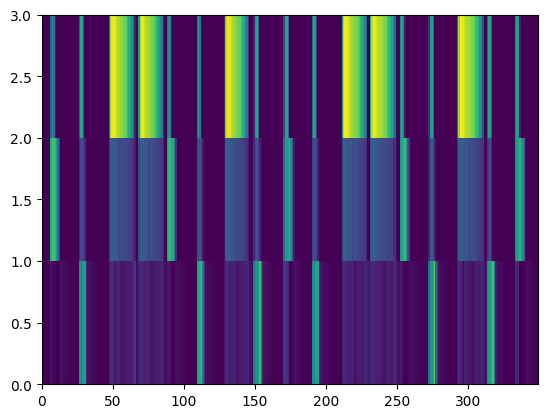

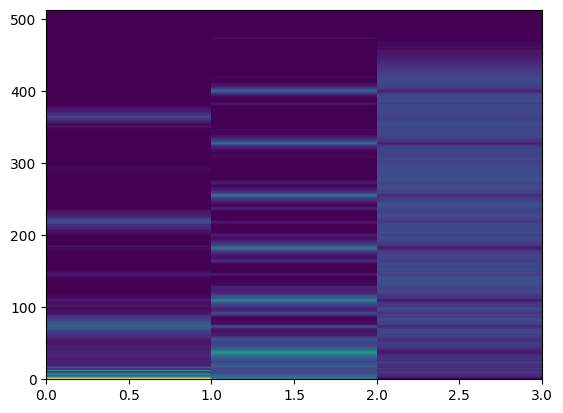

In [4]:
W_PCA, Z_PCA, xMean, xStd = getPCA(convertedScipySTFT, dims=3)
W_ICA, Z_ICA = getICA(Z_PCA)
W_NMF, H_NMF = getNMF(convertedScipySTFT, R=3, iterations=2000)

plt.pcolormesh(Z_PCA), plt.title("Z_PCA")
plt.show()

plt.pcolormesh(Z_ICA), plt.title("Z_ICA")
plt.show()

plt.pcolormesh(H_NMF), plt.title("H_NMF")
plt.show()

plt.pcolormesh(W_NMF), plt.title("W_NMF")
plt.show()

## Compare to sklearn implementations

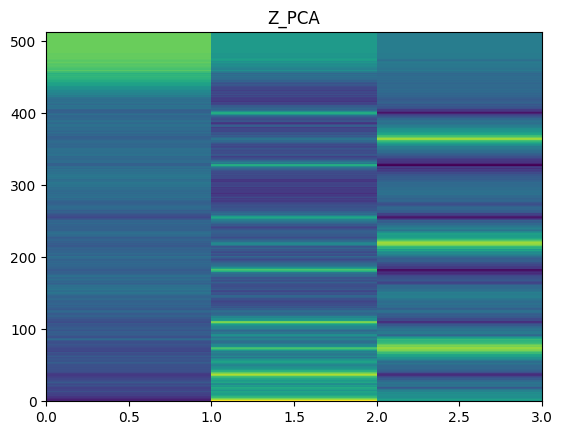

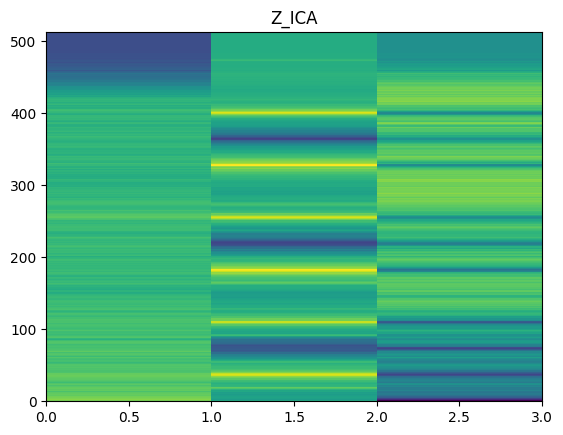

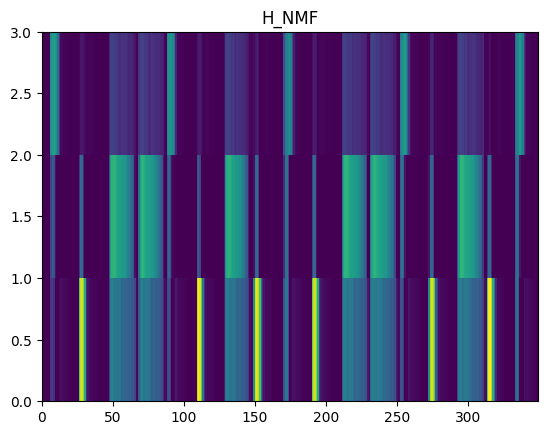

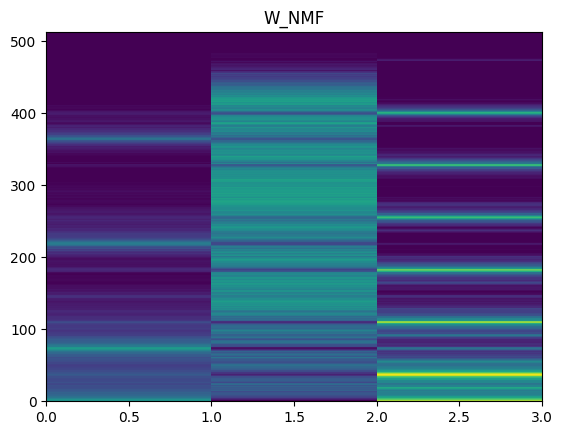

In [16]:
from sklearn.decomposition import PCA, FastICA, NMF

pca = PCA(n_components=3, whiten=True)
Z_PCA = pca.fit_transform(convertedScipySTFT)
W_PCA = pca.components_

ica = FastICA(n_components=3)
Z_ICA = ica.fit_transform(Z_PCA)
W_ICA = ica.components_

nmf = NMF(n_components=3, max_iter=400)
W_NMF = nmf.fit_transform(convertedScipySTFT)
H_NMF = nmf.components_


plt.pcolormesh(Z_PCA), plt.title("Z_PCA")
plt.show()

plt.pcolormesh(Z_ICA), plt.title("Z_ICA")
plt.show()

plt.pcolormesh(H_NMF), plt.title("H_NMF")
plt.show()

plt.pcolormesh(W_NMF), plt.title("W_NMF")
plt.show()